# Valhalla Experiments

We try Valhalla and its Python bindings on the data provided by [Microsoft](https://www.microsoft.com/en-us/research/publication/hidden-markov-map-matching-noise-sparseness/). Valhalla is an open source routing system allowing us to do map matching and linear referencing at the same time. We want to compare this approach with OSRM/OSMNX which causes quite a lot of problems.

#### Importing packages

In [1]:
import os
import sys
import urllib
import json
import time

sys.path.append('/usr/local/lib/python3.6/site-packages')

import valhalla
import pandas as pd
import matplotlib.pyplot as plt

#### URL of Microsoft data

In [2]:
gps_data_url = "https://www.microsoft.com/en-us/research/uploads/prod/2017/07/gps_data.txt"
road_network_url = "https://www.microsoft.com/en-us/research/uploads/prod/2017/07/road_network.zip"
ground_truth_url = "https://www.microsoft.com/en-us/research/uploads/prod/2017/07/ground_truth_route.txt"

#### Functions

In [3]:
def read_gps_data(data_path, verbose=False):
    with open(data_path) as f:

        # skip header
        f.readline()
        coords = []

        for line in f:
            coord = line.strip().split('\t')[2:]
            coords.append([float(elem) for elem in coord])
    
    if verbose:
        print("Length of trip : %d" % (len(coords)))        
    
    return coords
    

In [4]:
def create_query(coords, costing="auto", shape_match="walk_or_snap"):

    filters = {"attributes": ["matched.point",
                              "matched.type",
                              "matched.edge_index",
                              "matched.distance_along_edge",
                              "matched.distance_from_trace_point"],
               "action": "include"}

    query = {}
    query["costing"] = costing
    query["shape_match"] = shape_match
    query["filters"] = filters

    query["shape"] = [{"lat": pt[0], "lon": pt[1]} for pt in coords]

    return query


In [5]:
def make_valhalla_mapmatch_query(coords, return_time=False, verbose=False):
    
    start = time.time()
    
    query = json.dumps(create_query(coords))
    valhalla.Configure('./valhalla.json')
    actor = valhalla.Actor()
    response = actor.TraceAttributes(query)
    matched = json.loads(response)
    
    if verbose:
        print("Time taken for Map Matching : %.3f" % (time.time() - start))

    if return_time:
        return matched, time.time() - start
    else:
        return matched

In [6]:
def parse_response(matched, verbose=False):
    
    columns = ["mm_lon", "mm_lat", "edge_id", "pos", "dev", "type"]
    
    matched_trip = []
    n_matched = 0
    n_pts = 0
    
    for pt in matched["matched_points"]:
        
        n_pts += 1
        if pt["type"] == "unmatched":
            continue
        
        matched_trip.append([pt["lon"], 
                             pt["lat"],
                             pt["edge_index"],
                             pt["distance_along_edge"],
                             pt["distance_from_trace_point"],
                             pt["type"]])            
        n_matched += 1

    if verbose:
        print("Map Matching Accuracy : %.2f" % (n_matched / n_pts))
    
    return pd.DataFrame(matched_trip, columns=columns)

## Main

In [7]:
# Loading GPS Data
data_path = "data/gps_data.txt"
coords = read_gps_data(data_path, verbose=True)

Length of trip : 7531


In [8]:
# Map Matching
matched = make_valhalla_mapmatch_query(coords, verbose=True)

Time taken for Map Matching : 0.373


In [9]:
# Parse Map Matching Response
parsed_df = parse_response(matched, verbose=True)

Map Matching Accuracy : 0.99


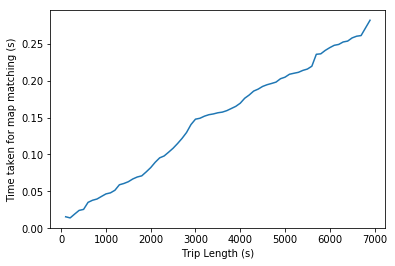

In [10]:
# time as a function of trip length

time_taken_arr = []
trip_length_arr = []

for trip_length in range(100, 7000, 100):
    
    _, time_taken = make_valhalla_mapmatch_query(coords[:trip_length], return_time=True)
    
    trip_length_arr.append(trip_length)
    time_taken_arr.append(time_taken)
    
plt.plot(trip_length_arr, time_taken_arr)
plt.xlabel("Trip Length (s)")
plt.ylabel("Time taken for map matching (s)")
plt.show()